In [11]:
import pandas 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

# Load the data
prescription_data: pandas.DataFrame = pandas.read_csv(filepath_or_buffer=r'data/csv/aggregated_dataset.csv')
demographics_data: pandas.DataFrame = pandas.read_csv(filepath_or_buffer=r'data/csv/city_code_population_demographics.csv')

# Merge the dataframes on the relevant key
aggregated_data: pandas.DataFrame = prescription_data.merge(right=demographics_data, on='city_code', how='left')

In [12]:
print("Number of unique cities with missing prescription values: ", aggregated_data[aggregated_data['agg_prescriptions'].isnull()]['city_code'].nunique())

Number of unique cities with missing prescription values:  57


In [13]:
# Add lagged variable for monthly prescriptions

# Create lagged variable for prescriptions filled - BY CITY 
aggregated_data['agg_prescriptions_lagged']: pandas.Series = None
for idx, row in aggregated_data.iterrows():
    if idx > 0 and row['city_code'] == aggregated_data.iloc[idx-1]['city_code']:
        aggregated_data.loc[idx, 'agg_prescriptions_lagged'] = row['agg_prescriptions'] - aggregated_data.iloc[idx-1]['agg_prescriptions']

# Drop null values
aggregated_data.dropna(subset="agg_prescriptions_lagged",inplace=True)

print("Number of unique cities with missing prescription values: ", aggregated_data[aggregated_data['agg_prescriptions'].isnull()]['city_code'].nunique())

Number of unique cities with missing prescription values:  0


In [14]:
# Handle missing values by filling numeric columns with their mean
numeric_columns = aggregated_data.select_dtypes(include=[np.number]).columns
aggregated_data[numeric_columns] = aggregated_data[numeric_columns].fillna(aggregated_data[numeric_columns].mean())

In [15]:
# Drop City07 & City12 - null for population
aggregated_data = aggregated_data[~aggregated_data['city_code'].isin(['City07','City12'])]

# Create year column
aggregated_data['month_year'] = pandas.to_datetime(aggregated_data['month_year'], format='%Y-%m')
aggregated_data['year'] = aggregated_data['month_year'].dt.year
aggregated_data['month'] = aggregated_data['month_year'].dt.month

# New feature - percentage of prescriptions filled by populations

aggregated_data = aggregated_data.assign(pct_prescriptions = lambda x: x['agg_prescriptions'] / x['province_population'])

In [16]:
aggregated_data['agg_prescriptions_lagged'] = aggregated_data['agg_prescriptions_lagged'].astype('float64')

### Random Forest Test

In [17]:
# Select features and target variable
cols_x = ['event_congress', 'event_meeting', 'F2F_visit', 'remote_visit',
            'Mass Mail Count', 'Rep Triggered Email Count', 'province_population',
            'month','year','agg_prescriptions_lagged','province_population_growth_rate_22_23',
            'province_median_age_total']

target = 'agg_prescriptions'

# Scale X and y data 
X = aggregated_data[cols_x]
y = aggregated_data[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest MSE:", rf_mse)
print("Random Forest R-squared:", rf_r2)


Random Forest MSE: 16.83660416666667
Random Forest R-squared: 0.8814740415513128


### V1 Decision Tree Test

Findings: 
- Cross validation of 3 is required due to small dataset
- CV of 3 fold revealed a max depth of 4 was more stable than max depth of 5 

In [18]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

dt_model = tree.DecisionTreeRegressor(max_depth=4)
cross_val_scores = cross_val_score(dt_model, X_train, y_train, cv=3, scoring='r2')
dt_model = dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

print("Cross Validation Scores: ", cross_val_scores)
print("Decision Tree MSE:", dt_mse)
print("Decision Tree OOS R-squared:", dt_r2)

Cross Validation Scores:  [0.74161659 0.74055091 0.78817012]
Decision Tree MSE: 34.982935049190175
Decision Tree OOS R-squared: 0.7537278975612847


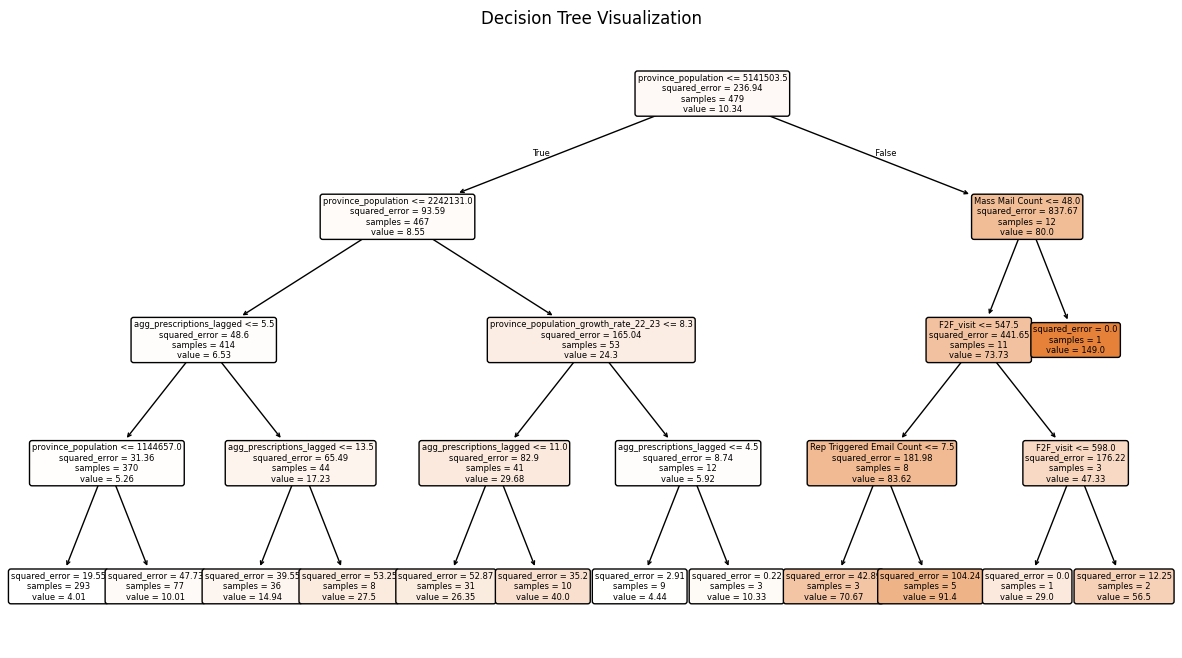

In [19]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(15, 8))
plot_tree(dt_model, filled=True, feature_names=cols_x, rounded=True, precision=2, fontsize=6)
plt.title('Decision Tree Visualization')
plt.show()

Feature Importances:
Feature: event_congress, Score: 0.00000
Feature: event_meeting, Score: 0.00000
Feature: F2F_visit, Score: 0.03393
Feature: remote_visit, Score: 0.00000
Feature: Mass Mail Count, Score: 0.05217
Feature: Rep Triggered Email Count, Score: 0.00810
Feature: province_population, Score: 0.77123
Feature: month, Score: 0.00000
Feature: year, Score: 0.00000
Feature: agg_prescriptions_lagged, Score: 0.08190
Feature: province_population_growth_rate_22_23, Score: 0.05267
Feature: province_median_age_total, Score: 0.00000


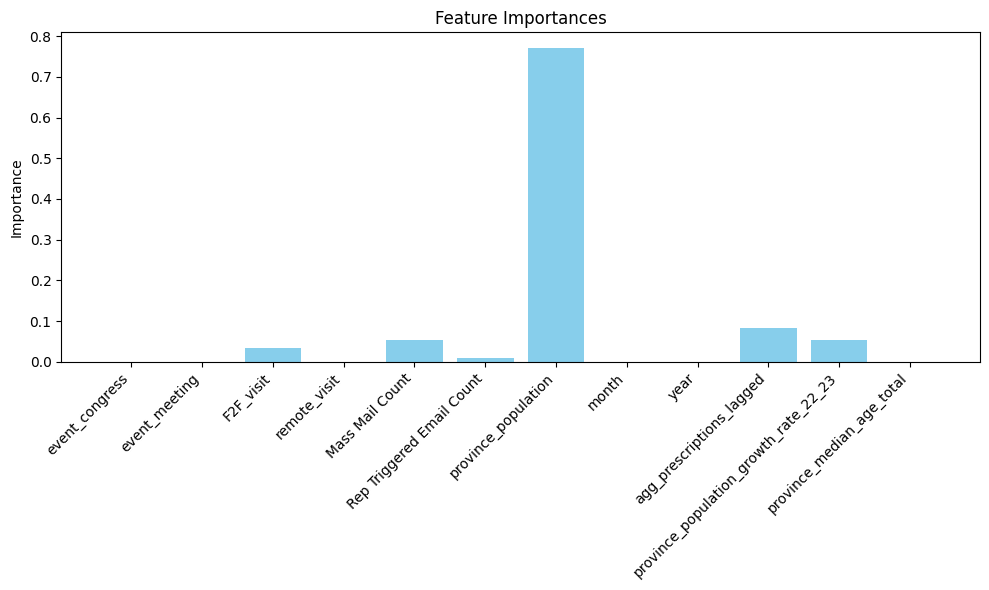

In [20]:
print("Feature Importances:")
importance = dt_model.feature_importances_
for feature, score in zip(cols_x, importance):
    print(f'Feature: {feature}, Score: {score:.5f}')

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(cols_x, importance, color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

In [21]:
X_train['agg_prescriptions_lagged'] = X_train['agg_prescriptions_lagged'].astype('float64')

/Users/mhoy/Development/MMAI-Marketing/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


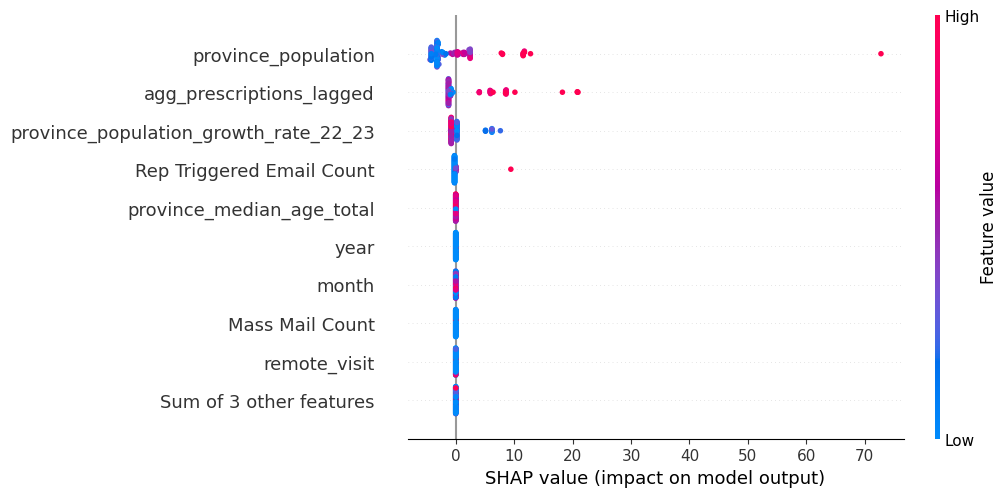

In [22]:
import shap

# SHAP values for direction of impact
explainer = shap.Explainer(dt_model, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

### V2 Decision Tree

Changes:

- Standard Scaled Features - Did not make a difference to scores or feature importance
- Removed features with low importance: ['year','Mass Email', 'event_meeting', 'remote_visit']

Result:
- Final Model - using cols_x_updated as final features to produce better interpretation of model results 

In [23]:
from sklearn.preprocessing import StandardScaler


def standard_scale_dataframe(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    
    # Create scaled columns with '_scaled' suffix
    scaled_columns = {col: col for col in df.columns}
    scaled_df = pandas.DataFrame(scaled_values, columns=[scaled_columns[col] for col in df.columns], index=df.index)
    
    # Combine original and scaled data
    return scaled_df

In [24]:
# Select features and target variable
cols_x = ['event_congress', 'event_meeting', 'F2F_visit', 'remote_visit',
            'Mass Mail Count', 'Rep Triggered Email Count', 'province_population',
            'month','year','agg_prescriptions_lagged','province_population_growth_rate_22_23',
            'province_median_age_total']

target = 'agg_prescriptions'

scaled_df = standard_scale_dataframe(aggregated_data[cols_x + [target]])

In [25]:
values_to_remove = ['year','Mass Mail Count', 'event_meeting', 'remote_visit','month','province_median_age_total']
cols_x_updated = [x for x in cols_x if x not in values_to_remove]                          

In [26]:
cols_x_updated

['event_congress',
 'F2F_visit',
 'Rep Triggered Email Count',
 'province_population',
 'agg_prescriptions_lagged',
 'province_population_growth_rate_22_23']

In [27]:
# For Scaled Data 

scaled_df = standard_scale_dataframe(aggregated_data[cols_x_updated + [target]])

# Scale X and y data 
X_scaled = scaled_df[cols_x_updated]
y_scaled = scaled_df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [28]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

dt_model = tree.DecisionTreeRegressor(max_depth=4)
cross_val_scores = cross_val_score(dt_model, X_train, y_train, cv=3, scoring='r2')
dt_model = dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

print("Cross Validation Scores: ", cross_val_scores)
print("Decision Tree MSE:", dt_mse)
print("Decision Tree OOS R-squared:", dt_r2)

Cross Validation Scores:  [0.73811814 0.74055091 0.74077003]
Decision Tree MSE: 0.16045785623356662
Decision Tree OOS R-squared: 0.7537278975612847


Feature: event_congress, Score: 0.05724
Feature: F2F_visit, Score: 0.02887
Feature: Rep Triggered Email Count, Score: 0.00810
Feature: province_population, Score: 0.77123
Feature: agg_prescriptions_lagged, Score: 0.08190
Feature: province_population_growth_rate_22_23, Score: 0.05267


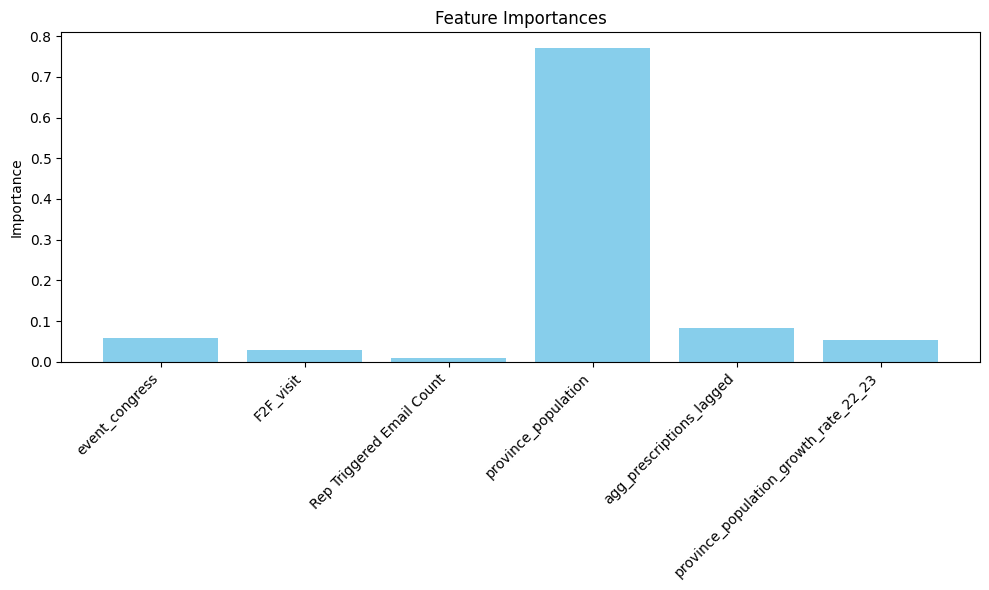

In [29]:
importance = dt_model.feature_importances_
for feature, score in zip(cols_x_updated, importance):
    print(f'Feature: {feature}, Score: {score:.5f}')

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(cols_x_updated, importance, color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

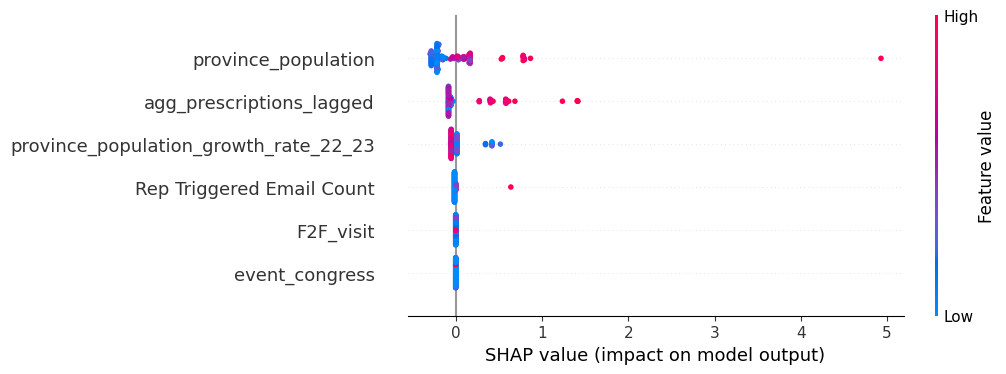

In [30]:
import shap

# SHAP values for direction of impact
explainer = shap.Explainer(dt_model, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

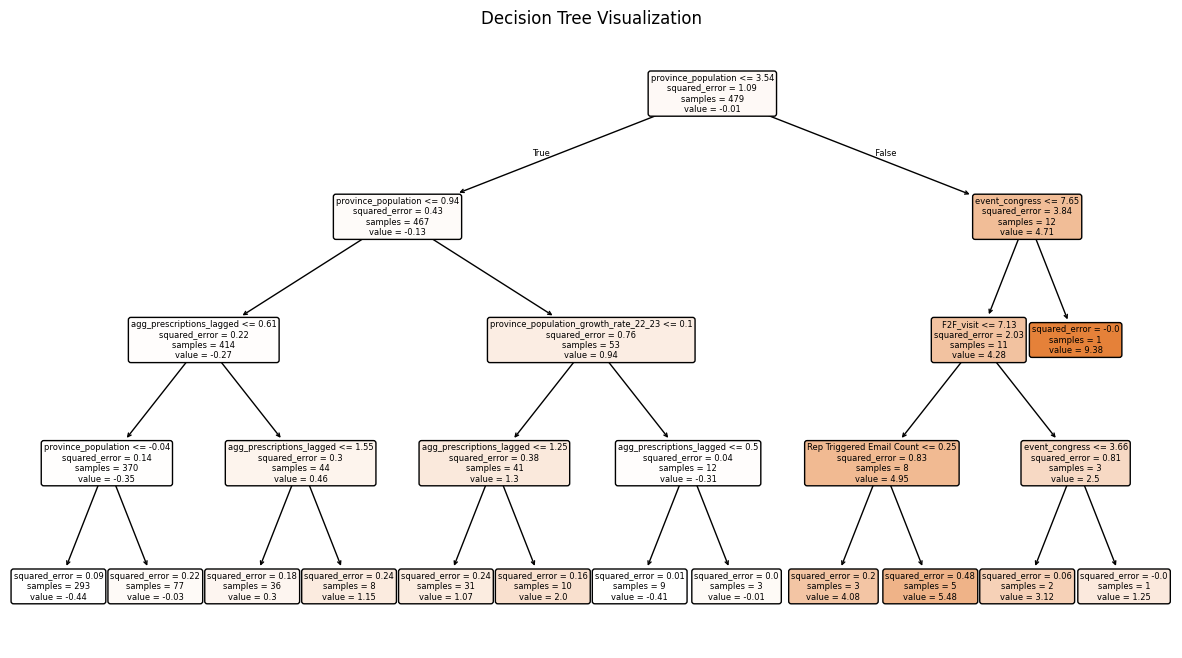

In [31]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(15, 8))
plot_tree(dt_model, filled=True, feature_names=cols_x_updated, rounded=True, precision=2, fontsize=6)
plt.title('Decision Tree Visualization')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text

# Function to calculate elasticity based on tree splits
def calculate_elasticity(tree, X, y):
    # Extract tree rules
    rules = export_text(tree, feature_names=list(X.columns))
    print("Tree Rules:\n", rules)
    
    # Initialize dictionary to store elasticities
    elasticities = {}

    # Loop through each feature
    for feature in X.columns:
        # Find splits for the feature
        splits = []
        for i in range(tree.tree_.node_count):
            if tree.tree_.feature[i] == X.columns.get_loc(feature):
                split_value = tree.tree_.threshold[i]
                splits.append(split_value)

        if splits:
            # Calculate average change in feature and corresponding change in target variable
            feature_range = X[feature].max() - X[feature].min()
            if feature_range == 0:  # Avoid division by zero
                continue

            target_range = y.max() - y.min()
            avg_change_feature = feature_range / len(splits)
            avg_change_target = target_range / len(splits)

            # Compute elasticity: % change in target / % change in feature
            elasticity = (avg_change_target / y.mean()) / (avg_change_feature / X[feature].mean())
            elasticities[feature] = elasticity

    return elasticities

# Calculate elasticities
elasticities = calculate_elasticity(dt_model, X_train, y_train)
import json
print("\nElasticities:\n", json.dumps(elasticities, indent=2))

Tree Rules:
 |--- province_population <= 3.54
|   |--- province_population <= 0.94
|   |   |--- agg_prescriptions_lagged <= 0.61
|   |   |   |--- province_population <= -0.04
|   |   |   |   |--- value: [-0.44]
|   |   |   |--- province_population >  -0.04
|   |   |   |   |--- value: [-0.03]
|   |   |--- agg_prescriptions_lagged >  0.61
|   |   |   |--- agg_prescriptions_lagged <= 1.55
|   |   |   |   |--- value: [0.30]
|   |   |   |--- agg_prescriptions_lagged >  1.55
|   |   |   |   |--- value: [1.15]
|   |--- province_population >  0.94
|   |   |--- province_population_growth_rate_22_23 <= 0.10
|   |   |   |--- agg_prescriptions_lagged <= 1.25
|   |   |   |   |--- value: [1.07]
|   |   |   |--- agg_prescriptions_lagged >  1.25
|   |   |   |   |--- value: [2.00]
|   |   |--- province_population_growth_rate_22_23 >  0.10
|   |   |   |--- agg_prescriptions_lagged <= 0.50
|   |   |   |   |--- value: [-0.41]
|   |   |   |--- agg_prescriptions_lagged >  0.50
|   |   |   |   |--- value: [-